卓球の球がテーブルに当たったかどうかを音から検知してみる

最初にサンプル音源の 「時間-音の強度」のグラフとこれを短時間フーリエ変換して得られる 「時間-周波数」のグラフを図示する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import pickle
%matplotlib inline

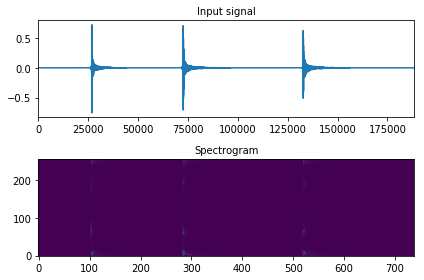

In [5]:
# 短時間フーリエ変換
def stft_core(x, win, step,IMG_SIZE):
    l = len(x) # 入力信号の長さ
    N = len(win) # 窓幅
    M = int(np.ceil(float(l - N + step) / step)) # スペクトログラムの時間フレーム数
    
    new_x = np.zeros(N + ((M - 1) * int(step)), dtype = float)
    new_x[: l] = x # 信号をいい感じの長さにする
    
    X = np.zeros([M, N], dtype = complex) # スペクトログラムの初期化(複素数型)
    X2 = np.zeros([(M-M%IMG_SIZE+IMG_SIZE), N], dtype = complex) # あとで使う
    
    for m in range(M):
        start = int(step * m)
        X[m, :] = np.fft.fft(new_x[start : start + N] * win)
        X2[m, :] = np.fft.fft(new_x[start : start + N] * win)

    return X,X2


def stft(filename,IMG_SIZE):
    # file read
    wf = wave.open(filename , "r" )
    fs = wf.getframerate()  # サンプリング周波数
    g = wf.readframes(wf.getnframes())
    wf.close()

    # -1～1に正規化
    g = np.frombuffer(g, dtype= "int16")/32768.0    

    #fftLen = IMG_SIZE # とりあえず
    fftLen = (IMG_SIZE-1)*2
    win = np.hamming(fftLen) # ハミング窓
    step = fftLen / 2                 

    spectrogram,spectrogram2 = stft_core(g, win, step,IMG_SIZE)

    ### Plot
    fig = plt.figure()
    fig.add_subplot(211)
    plt.plot(g)
    plt.xlim([0, len(g)])
    plt.title("Input signal", fontsize = 10)
    
    fig.add_subplot(212)
    plt.imshow(abs(spectrogram[:, : int(fftLen / 2 + 1)].T), aspect = "auto", origin = "lower")
    plt.title("Spectrogram", fontsize = 10)
    # Spectrogramの周波数は実際にはfreqList = np.fft.fftfreq(fftLen, d=1.0/fs) 
    plt.tight_layout()
    plt.show()
    
    return spectrogram2, fftLen, g


if __name__ == "__main__":
    filename = "sound.wav"
    IMG_SIZE = 256
    spectrogram2, fftLen, g = stft(filename,IMG_SIZE)


次に学習させるためのinputデータをつくる

短時間フーリエ変換データを一定時間ごとに区切って256✕256✕n枚の画像データのようにする


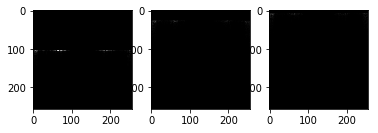

In [3]:
def calc_data(spectrogram2, fftLen,IMG_SIZE):
    #"""
    def min_max_normalixstion(x):
        x_min = x.min()
        x_max = x.max()
        x_norm = ((x-x_min)/(x_max - x_min)*255).astype("uint8")
        return x_norm
    """
    def min_max_normalixstion(x):
        return x
    """

    data_tmp = min_max_normalixstion(abs(spectrogram2[:, : int(fftLen / 2 + 1)]))
    data = data_tmp.reshape(int((len(data_tmp)*IMG_SIZE)/(IMG_SIZE*IMG_SIZE)),IMG_SIZE,IMG_SIZE)
    
    row, col = 1, 3
    fig = plt.figure()
    for i in range(row*col):
        sp = fig.add_subplot(row, col, i+1)  
        sp.imshow(data[i], cmap='gray', interpolation='none')
    plt.show()
    
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    
    return data

if __name__ == "__main__":
    data = calc_data(spectrogram2, fftLen,IMG_SIZE)

以上でlen(data)/256 = 3パターンのinputデータの作成が終了

次にこれらのデータに、球がテーブルにあった音を含むかどうかのラベルづけをおこなう

ここで卓球の球がテーブルに当たったときの音は下図より26750, 72600, 132800あたりである

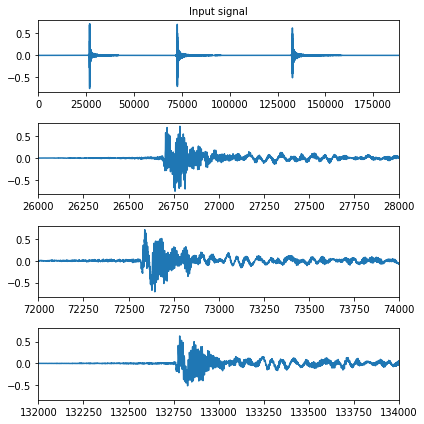

In [6]:
fig = plt.figure(figsize=(6,6))

fig.add_subplot(411)
plt.plot(g)
plt.xlim([0, len(g)])
plt.title("Input signal", fontsize = 10)

fig.add_subplot(412)
plt.plot(g)
plt.xlim([26000, 28000])

fig.add_subplot(413)
plt.plot(g)
plt.xlim([72000, 74000])
 
fig.add_subplot(414)
plt.plot(g)
plt.xlim([132000, 134000])

plt.tight_layout()
plt.show()

フーリエ変換後で考えると

In [7]:
ydata_tmp = [26750,72600,132800]
ydata_ft = []
for i in range(3):
    ydata_ft.append(int(ydata_tmp[i]/fftLen*2))
print(ydata_ft)

[104, 284, 520]


次にこれらがどの256区間に入るか調べてそれらを目的変数とする

In [8]:
target = np.zeros([int(len(data)),2], dtype = "uint8")
target[:,0]=1

for i in range(len(ydata_ft)):
    tmp = int(ydata_ft[i]/256)
    target[tmp][0]=0
    target[tmp][1]=1
    
print(target)

[[0 1]
 [0 1]
 [0 1]]


これで目的変数のセット完了

In [374]:
with open('target_0.pickle', mode='wb') as f:
     pickle.dump(target, f)

data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
with open('data_0.pickle', mode='wb') as f:
     pickle.dump(data, f)

In [375]:
with open('target.pickle', mode='rb') as f:
    target_tmp = pickle.load(f)

with open('data.pickle', mode='rb') as f:
    data_tmp = pickle.load(f)


以上の要領で他の音源データについても入力データを作成していく


In [ ]:
if __name__ == "__main__":
    filename = "sound1.wav"
    IMG_SIZE = 256
    spectrogram2, fftLen = stft(filename,IMG_SIZE)
    
    data = calc_data(spectrogram2, fftLen,IMG_SIZE)
    
    ydata_tmp = [228438,262174,320607,355446,648711,677596,726768,780349,802840,846279,1189377,1212529,1253101,1286397,1315282,
    1677564,1712623,1762456,1822212,1853743,1884834,1919673,2210953,2250864,2291877,2344797,2377210,2709283,2754706,2802775,
    2841583,2871792,2910379,2933311,2974324,3008061,3068478,3096261,3143889,3176082,3243114,3285891,3633399,3664269,3728434,
    4116514,4151353,4208463,4510107,4540536,4599850,4677687,4709439,4763461,5077894,5111851,5162125,5207548,5239962,5543370,
    5575342,5952397,5983488,6035967,6383034,6418755,6464178,6506073,6533856,6570459,6613897,6660423,6693939,6736054,7028217,
    7066363,7119283,7171321,7463263,7495897,7558519,7627315,7693465,7721910,7988935,8020908,8079561,8128732,8152105,8198631,
    8223988,8288374,8351878,8395978,8799052,8838081,8879976,9198378,9235422,9278640,9344128,9406089,9443133,9474885,9508180,
    9545886,9821731,9853263,9889425,10232302,10263393,10305288,10366587,10396134,10447731,10479483]


In [102]:
ydata_ft = []
for i in range(len(ydata_tmp)):
    ydata_ft.append(int(ydata_tmp[i]/fftLen*2))
print(ydata_ft)

[104, 284, 520]


In [74]:
target = np.zeros([int(len(data)),2], dtype = "uint8")
target[:,0]=1

for i in range(len(ydata_ft)):
    tmp = int(ydata_ft[i]/256)
    target[tmp][0]=0
    target[tmp][1]=1

In [81]:
with open('target.pickle', mode='wb') as f:
     pickle.dump(target, f)

data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
with open('data.pickle', mode='wb') as f:
     pickle.dump(data, f)